In [1]:
from __future__ import print_function, division
from builtins import range

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPool1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

In [3]:
# Download the word vectors:
# http://nlp.stanford.edu/data/glove.6B.zip

In [4]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [5]:
# load in pre-tained word vectors
print("Loading word vectors...")
word2vec = {}
with open(os.path.join('data/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [6]:
# prepare the text smaples and their labels
print('Loading in comments...')

train = pd.read_csv('data/train.csv')
sentences = train['comment_text'].fillna('DUMMY_VALUE').values
possible_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
targets = train[possible_labels].values

Loading in comments...


In [7]:
# convert the sentences into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [8]:
print('max sequence length: ', max(len(s) for s in sentences))
print('min sequence length: ', min(len(s) for s in sentences))
s = sorted(len(s) for s in sequences)
print('median sequence length: ', s[len(s) // 2])
print('max word index: ', max(max(seq) for seq in sequences if len(seq) > 0))

max sequence length:  5000
min sequence length:  6
median sequence length:  35
max word index:  19999


In [9]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 210337 unique tokens.


In [10]:
# pad sequence so that we get N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor: ', data.shape)

Shape of data tensor:  (159571, 100)


In [11]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) +1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [12]:
from sklearn.model_selection import train_test_split    
from sklearn.preprocessing import MinMaxScaler

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=VALIDATION_SPLIT, random_state=1)

In [14]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

In [15]:
print('Building model...')
import time
start_time = time.time()
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
# x = MaxPooling1D(3)(x)
# x = Conv1D(128, 3, activation='relu')(x)
# x = MaxPooling1D(3)(x)
# x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPool1D()(x)
# x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)
print("--- %s seconds ---" % (time.time() - start_time))

Building model...
--- 0.08488297462463379 seconds ---


In [16]:
start_time = time.time()
model = Model(input_, output)
model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.008952856063842773 seconds ---


In [17]:
print('Training model...')
start_time = time.time()
r = model.fit(
    X_train,y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test)
)
print("--- %s seconds ---" % (time.time() - start_time))

Training model...
Epoch 1/10
998/998 [==============================] - 56s 56ms/step - loss: 0.0679 - accuracy: 0.8526 - val_loss: 0.0614 - val_accuracy: 0.8866
Epoch 2/10
998/998 [==============================] - 45s 45ms/step - loss: 0.0520 - accuracy: 0.8444 - val_loss: 0.0607 - val_accuracy: 0.9372
Epoch 3/10
998/998 [==============================] - 54s 54ms/step - loss: 0.0476 - accuracy: 0.8569 - val_loss: 0.0520 - val_accuracy: 0.7827
Epoch 4/10
998/998 [==============================] - 60s 60ms/step - loss: 0.0447 - accuracy: 0.8390 - val_loss: 0.0570 - val_accuracy: 0.5860
Epoch 5/10
998/998 [==============================] - 73s 73ms/step - loss: 0.0423 - accuracy: 0.8182 - val_loss: 0.0684 - val_accuracy: 0.9090
Epoch 6/10
998/998 [==============================] - 96s 96ms/step - loss: 0.0403 - accuracy: 0.7988 - val_loss: 0.0534 - val_accuracy: 0.8270
Epoch 7/10
998/998 [==============================] - 88s 89ms/step - loss: 0.0384 - accuracy: 0.7822 - val_loss: 0.05

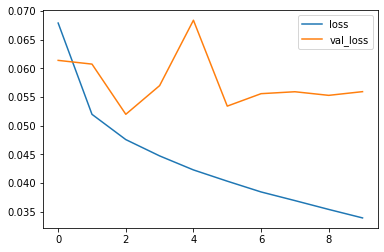

In [18]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

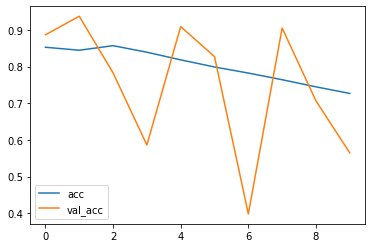

In [19]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [20]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.9911110541337877


In [21]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer

In [22]:
start_time = time.time()
probability = model.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))

--- 8.440582990646362 seconds ---


In [23]:
thresh = 0.49
predictions = np.array([[1 if i > thresh else 0 for i in j] for j in probability])

In [24]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.85      0.69      0.76      3103
           1       0.42      0.21      0.28       303
           2       0.84      0.72      0.78      1687
           3       0.54      0.31      0.39       101
           4       0.70      0.73      0.71      1574
           5       0.71      0.30      0.43       286

   micro avg       0.79      0.67      0.72      7054
   macro avg       0.68      0.49      0.56      7054
weighted avg       0.78      0.67      0.72      7054
 samples avg       0.06      0.06      0.06      7054



/home/ahsan/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ahsan/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,predictions)

0.9178129406235312